In [10]:
# Imports de librerias

import os
import requests
import pandas as pd
from io import StringIO
from datetime import datetime
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# 1. Descargar HTML y leer la tabla

url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Aviso de error si falla la solicitud
html = response.text

tables = pd.read_html(StringIO(html))
df = tables[0].copy()  # Usar primera tabla como target

In [12]:
# 2. Normalizar columnas

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^a-z0-9_]', '', regex=True)

In [13]:
# 3. Renombrar columnas y garantizar congruencia

rename_dict = {}
for col in df.columns:
    if 'song' in col or 'title' in col:
        rename_dict[col] = 'title'
    elif 'artist' in col:
        rename_dict[col] = 'artist'
    elif 'stream' in col:
        rename_dict[col] = 'streams_billions'
    elif 'publish' in col or 'release' in col:
        rename_dict[col] = 'release_date'
df = df.rename(columns=rename_dict)

In [14]:
# 5. Limpiar y transformar datos

df = df.dropna(subset=['title', 'artist', 'streams_billions'])  # Drop de columnas vacias en key cols
df = df[~df['title'].str.contains('As of', case=False, na=False)]  # Limpieza de datos adicionales
df['streams_billions'] = pd.to_numeric(df['streams_billions'].str.replace(',', ''), errors='coerce')  # Numericos
df = df.drop_duplicates().reset_index(drop=True)  # Eliminar duplicados
df['scraping_date'] = datetime.utcnow().date()  # Incluir fecha

In [15]:
# 6. Guardar en base de datos SQLite

db_path = 'spotify_streams.db'
conn = sqlite3.connect(db_path)
df.to_sql('most_streamed_spotify', conn, if_exists='replace', index=False)
conn.close()
print(f"Data saved to {db_path}. Rows: {len(df)}")

Data saved to spotify_streams.db. Rows: 100


In [16]:
# 7. Verificar datos guardados

conn = sqlite3.connect(db_path)
print(pd.read_sql("SELECT * FROM most_streamed_spotify LIMIT 5", conn))
conn.close()

  rank                title                    artist  streams_billions  \
0    1    "Blinding Lights"                The Weeknd             5.172   
1    2       "Shape of You"                Ed Sheeran             4.674   
2    3            "Starboy"  The Weeknd and Daft Punk             4.241   
3    4    "Sweater Weather"         The Neighbourhood             4.228   
4    5  "Someone You Loved"             Lewis Capaldi             4.154   

        release_date  ref scraping_date  
0   29 November 2019  [1]    2025-12-08  
1     6 January 2017  [2]    2025-12-08  
2  21 September 2016  [3]    2025-12-08  
3    3 December 2012  [4]    2025-12-08  
4    8 November 2018  [5]    2025-12-08  


In [17]:
# 8. Análisis básico

total_streams = df['streams_billions'].sum()
avg_streams = df['streams_billions'].mean()
top_song = df.loc[df['streams_billions'].idxmax(), 'title']
top_artist = df.loc[df['streams_billions'].idxmax(), 'artist']
print(f"Total streams (billions): {total_streams:.2f}")
print(f"Avg streams: {avg_streams:.2f}")
print(f"Top: '{top_song}' by {top_artist}")

Total streams (billions): 303.13
Avg streams: 3.03
Top: '"Blinding Lights"' by The Weeknd


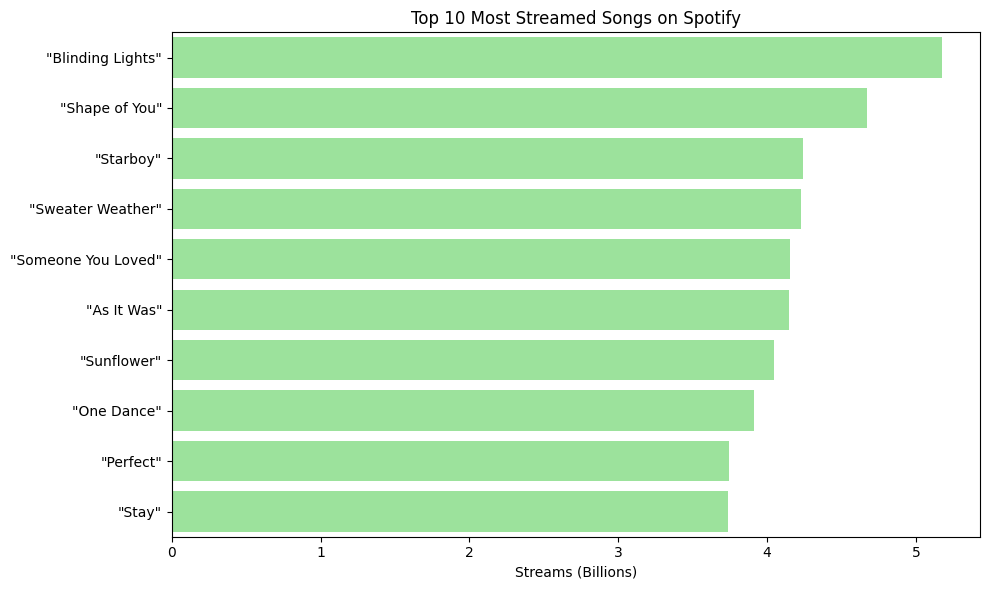

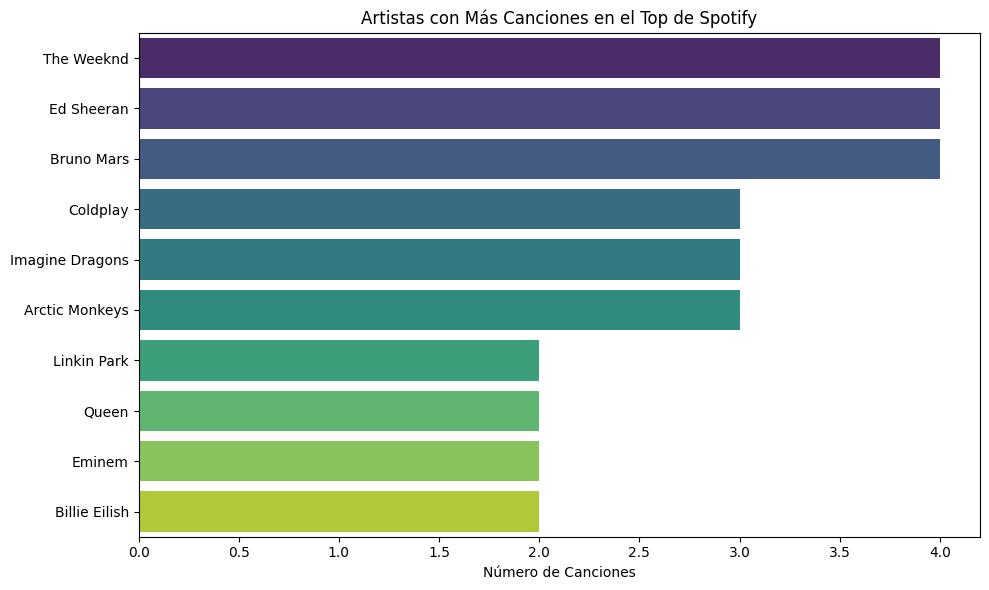

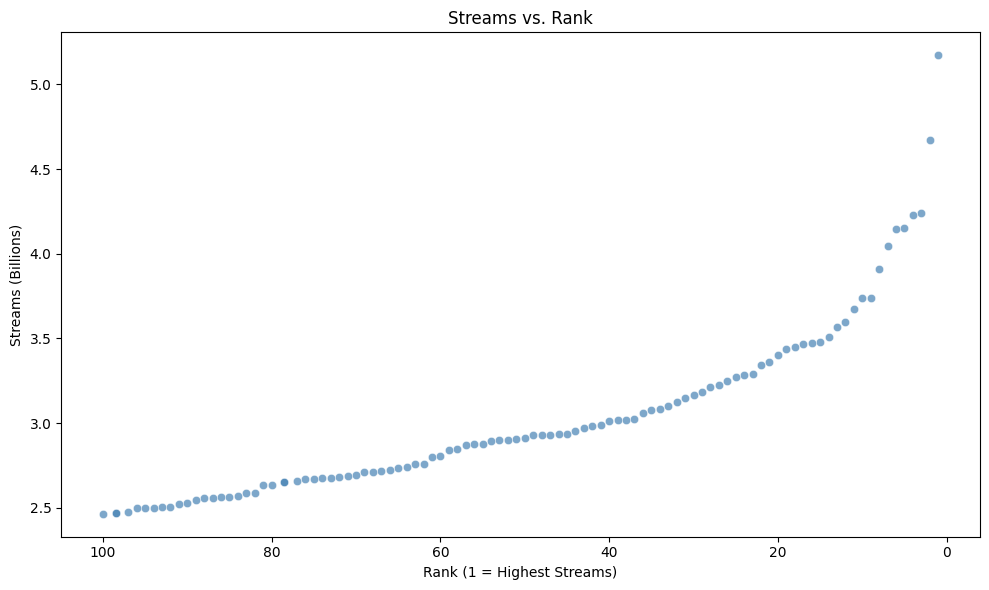

In [18]:
# 8. Visualización de datos

# Plot 1: Top 10 songs

plt.figure(figsize=(10,6))
sns.barplot(data=df.nlargest(10, 'streams_billions'), x='streams_billions', y='title', color='lightgreen')
plt.title('Top 10 Most Streamed Songs on Spotify')
plt.xlabel('Streams (Billions)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Plot 2: Top artistas por song count

artist_counts = df['artist'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=artist_counts.values, y=artist_counts.index, hue=artist_counts.index, palette='viridis', legend=False)
plt.title('Artistas con Más Canciones en el Top de Spotify')
plt.xlabel('Número de Canciones')
plt.ylabel('')
plt.tight_layout()
plt.savefig('top_artists.png')
plt.show()

# Plot 3: Streams vs. rank (usa index como proxy si no hay 'rank')

df['rank'] = df['streams_billions'].rank(ascending=False)  # Agregar rank en base a los streams
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='rank', y='streams_billions', color='steelblue', alpha=0.7)
plt.gca().invert_xaxis()  # Rank 1 a la derecha
plt.title('Streams vs. Rank')
plt.xlabel('Rank (1 = Highest Streams)')
plt.ylabel('Streams (Billions)')
plt.tight_layout()
plt.show()